In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
import random
import time

In [2]:
import os
import sys
sys.path.append("../codes")

In [3]:
from maml_utils import loss_function, np_to_tensor, compute_loss, compute_gradients, apply_gradients, train_batch, copy_model, eval_sine_test

In [4]:
from dataset import Generator, Dataset

class ExpGenerator(Generator):

    def _sample_parameters(self):
        parameters = {}
        parameters['coefficient'] = np.random.uniform(1., 2.)
        parameters['exponent'] = np.random.uniform(-2., 2.)
        return parameters

    def _sample_x(self):
        return np.random.uniform(-1, 1, self.K)

    def equally_spaced_samples(self, K=None):
        '''Returns `K` equally spaced samples.'''
        if K is None:
            K = self.K
        return self.batch(x=np.linspace(-1, 1, K))

    def f(self, x):
        '''Exp function.'''
        return self.parameters['coefficient'] * np.exp(self.parameters['exponent'] * x)

class ExpDataset(Dataset):
    def __init__(self, **kwargs):
        assert 'generator' not in kwargs
        generator_class = ExpGenerator
        super().__init__(generator_class=generator_class, **kwargs)

General Trainer class

In [5]:
class Trainer():
    
    def __init__(self, model):
        self.model = model
        
    def train(dataset_train):
        raise NotImplementedError
        
    def evaluate(dataset_test):
        raise NotImplementedError
        
    def save(path):
        raise NotImplementedError

Model

In [6]:
class Model(keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40, input_shape=(40,))
        self.out = keras.layers.Dense(1, input_shape=(40,))
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x
    
    def call(self, x):
        return self.forward(x)

Trainer

In [7]:
def split_context_target(xs, ys, n_context):
    """Randomly split a set of x,y samples into context and target sets"""
    context_mask = np.zeros(xs.shape[0], dtype=bool)
    context_mask[[i for i in random.sample(range(xs.shape[0]), n_context)]] = True

    context_xs = xs[context_mask]
    context_ys = ys[context_mask]

    target_xs = xs[~context_mask]
    target_ys = ys[~context_mask]

    return context_xs, context_ys, target_xs, target_ys

In [8]:
class MAMLTrainer(Trainer):

    def __init__(self, model, model_class=Model):
        self.model_class = model_class
        self.model = model
        x, _ = np_to_tensor([np.ones((10,1)), np.ones((10,1))])
        self.model.forward(x)
        
    def train(self, dataset_train, n_epochs=1, n_iter=100, min_context=1, max_context=10, lr_inner=0.01, batch_size=1, log_steps=1000):
        optimizer = keras.optimizers.Adam()
    
        # Step 2: instead of checking for convergence, we train for a number
        # of epochs
        losses = []
        test_losses_all = []
        test_losses_epoch = []
        for e in range(n_epochs):
            total_loss = 0
            start = time.time()
            # Step 3 and 4
            for i, t in enumerate(dataset_train(size=n_iter)):
                x, y = np_to_tensor(t.batch())
                n_context = random.choice(range(min_context, max_context+1))
                context_x, context_y, target_x, target_y = split_context_target(x, y, n_context)
                
                with tf.GradientTape() as test_tape:
                    # test_tape.watch(model.trainable_variables)
                    # Step 5
                    with tf.GradientTape() as train_tape:
                        train_loss, _ = compute_loss(self.model, context_x, context_y)
                    # Step 6
                    gradients = train_tape.gradient(train_loss, self.model.trainable_variables)
                    k = 0
                    model_copy = copy_model(self.model, context_x, model_class=self.model_class)
                    for j in range(len(model_copy.layers)):
                        model_copy.layers[j].kernel = tf.subtract(self.model.layers[j].kernel,
                                    tf.multiply(lr_inner, gradients[k]))
                        model_copy.layers[j].bias = tf.subtract(self.model.layers[j].bias,
                                    tf.multiply(lr_inner, gradients[k+1]))
                        k += 2
                    # Step 8
                    test_loss, logits = compute_loss(model_copy, target_x, target_y)
                    test_losses_all.append(test_loss.numpy())
                # Step 8
                gradients = test_tape.gradient(test_loss, self.model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

                # Logs
                total_loss += test_loss
            test_losses_epoch.append(test_loss.numpy())
            loss = total_loss / n_iter
            losses.append(loss.numpy())

            print('Epoch {}: mean loss = {}, Time to run {} steps = {}'.format(e, loss, n_iter, time.time() - start))
            start = time.time()
            print(losses)
        plt.plot(losses)
        plt.show()
        
        plt.plot(test_losses_all)
        plt.show()
        
        plt.plot(test_losses_epoch)
        plt.show()
            
    def save(self, path):
        self.model.save_weights(path)
        
    def load(self, path):
        self.model.built = True
        self.model.load_weights(path)
            
    def evaluate(self, generator_test, **kwargs):
        
        assert generator_test.K == generator_test.x.size
        
        
        # generate equally spaced samples for ploting
        x_test, y_test = generator_test.equally_spaced_samples(200)

        # batch used for training
        x, y = generator_test.batch()
        
        fit_res_all = []
        
        print('Parameters : {}'.format(generator_test.parameters))
        for index in range(1, generator_test.K+1):
            print('Number of context points {}'.format(index))
            fit_res = self.eval_sinewave_for_test(x[:index], y[:index], x_test, y_test, **kwargs)
            print('Loss :', fit_res[-1][-1])
            fit_res_all.append(fit_res)
            
        return fit_res_all
        
        
        
        
    def eval_sinewave_for_test(self, x, y, x_test, y_test, num_steps=(10,), lr=0.01, plot=True):
        '''Evaluates how the sinewave addapts at dataset.

        The idea is to use the pretrained model as a weight initializer and
        try to fit the model on this new dataset.

        Args:
            model: Already trained model.
            sinusoid_generator: A sinusoidGenerator instance.
            num_steps: Number of training steps to be logged.
            lr: Learning rate used for training on the test data.
            plot: If plot is True than it plots how the curves are fitted along
                `num_steps`.

        Returns:
            The fit results. A list containing the loss, logits and step. For
            every step at `num_steps`.
        '''

        # copy model so we can use the same model multiple times
        copied_model = copy_model(self.model, x, model_class=self.model_class)

        # use SGD for this part of training as described in the paper
        optimizer = keras.optimizers.SGD(learning_rate=lr)

        # run training and log fit results
        fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)

        # plot
        train, = plt.plot(x, y, '^')
        ground_truth, = plt.plot(x_test, y_test)
        plots = [train, ground_truth]
        legend = ['Training Points', 'True Function']
        for n, res, loss in fit_res:
            cur, = plt.plot(x_test, res[:, 0], '--')
            plots.append(cur)
            legend.append(f'After {n} Steps')
        plt.legend(plots, legend)
        plt.ylim(0., 5.)
        plt.xlim(-1.5, 1.5)
        if plot:
            plt.show()

        return fit_res
        
        
    
    

In [9]:
model = Model()
trainer = MAMLTrainer(model)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [10]:
type(trainer.model)

__main__.Model

In [ ]:
trainer.train(ExpDataset, n_epochs=200)

trainer.save('../outputs/exp.tf')

In [12]:
trainer.load('../outputs/exp.tf')

In [13]:
generator_test = ExpGenerator(
    K = 5,
    x = np.array([0, 0.5, -0.5, 1, -1]),
    parameters = {
        'coefficient': 1.5,
        'exponent': 1.
    }
)

Parameters : {'coefficient': 1.5, 'exponent': 1.0}
Number of context points 1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



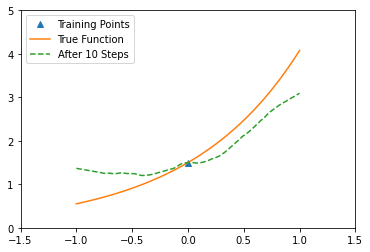

Loss : tf.Tensor(0.19941957323026394, shape=(), dtype=float64)
Number of context points 2

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



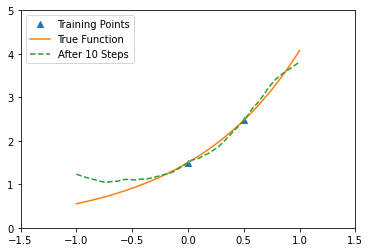

Loss : tf.Tensor(0.04973941292581457, shape=(), dtype=float64)
Number of context points 3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



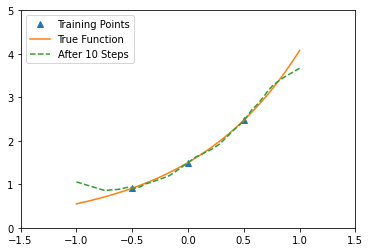

Loss : tf.Tensor(0.022892880650951283, shape=(), dtype=float64)
Number of context points 4

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



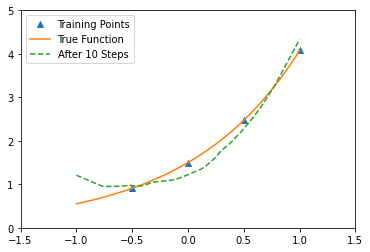

Loss : tf.Tensor(0.06165152378336788, shape=(), dtype=float64)
Number of context points 5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



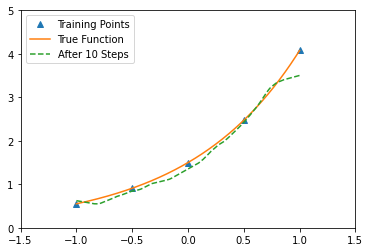

Loss : tf.Tensor(0.01892048155283278, shape=(), dtype=float64)


In [14]:
fit_res_all = trainer.evaluate(generator_test)

In [15]:
ys = fit_res_all[0][0][1].numpy()

In [16]:
ys.shape

(200, 1)

In [17]:
np.save('exp_maml', ys)